In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Loading the tokenizer
tokenizer = BartTokenizer.from_pretrained('/content/drive/MyDrive/bart_tokenizer')

# Loading the model
model = BartForConditionalGeneration.from_pretrained('/content/drive/MyDrive/bart_model')

In [7]:
import pandas as pd

# Load the file
file_path = '/content/drive/MyDrive/Colab Notebooks/updated_cleaned_data.csv'
data = pd.read_csv(file_path)

In [12]:
# Sample 20,000 records from the dataset
sampled_data = data.sample(n=100, random_state=42)

In [13]:
# Select the 'document' column
documents = sampled_data['document'].dropna().tolist()                           # Dropping any NaN values if present

In [14]:
def generate_summary(text):
    try:
        # Tokenize the input with truncation to handle long text
        inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

        # Generate the summary with controlled parameters
        summary_ids = model.generate(
            inputs['input_ids'],
            max_length=150,
            min_length=40,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )

        # Decode and return the summary text
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    except Exception as e:
        print(f"Error generating summary for text: {text[:100]}...")             # Print a snippet of the text
        print(f"Error message: {e}")
        return None

In [15]:
from tqdm import tqdm

# Initialize an empty list to store summaries
all_summaries = []

# Define batch size
batch_size = 10

# Process documents in batches with a progress bar
for i in tqdm(range(0, len(documents), batch_size), desc="Processing batches"):
    # Get the current batch of documents
    batch = documents[i:i + batch_size]

    # Generate summaries for the batch
    batch_summaries = [generate_summary(text) for text in batch]

    # Append the batch summaries to the main list
    all_summaries.extend(batch_summaries)

# Add the summaries to the DataFrame
sampled_data['predicted_summary'] = all_summaries

Processing batches: 100%|██████████| 10/10 [28:55<00:00, 173.53s/it]


In [16]:
# Save the results to a new CSV file in Google Drive
output_path = '/content/drive/MyDrive/dataset_with_summaries.csv'
sampled_data.to_csv(output_path, index=False)

print("Summaries saved successfully.")

Summaries saved successfully.


In [32]:
file_path = '/content/drive/MyDrive/dataset_with_summaries.csv'
sampled_data = pd.read_csv(file_path)

In [33]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment_score(text):
    # Get the sentiment score for the text
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  # Compound score is a general sentiment indicator

# Calculate sentiment scores for the columns
sampled_data['document_sentiment'] = sampled_data['document'].apply(get_sentiment_score)
sampled_data['summary_sentiment'] = sampled_data['summary'].apply(get_sentiment_score)
sampled_data['predicted_summary_sentiment'] = sampled_data['predicted_summary'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


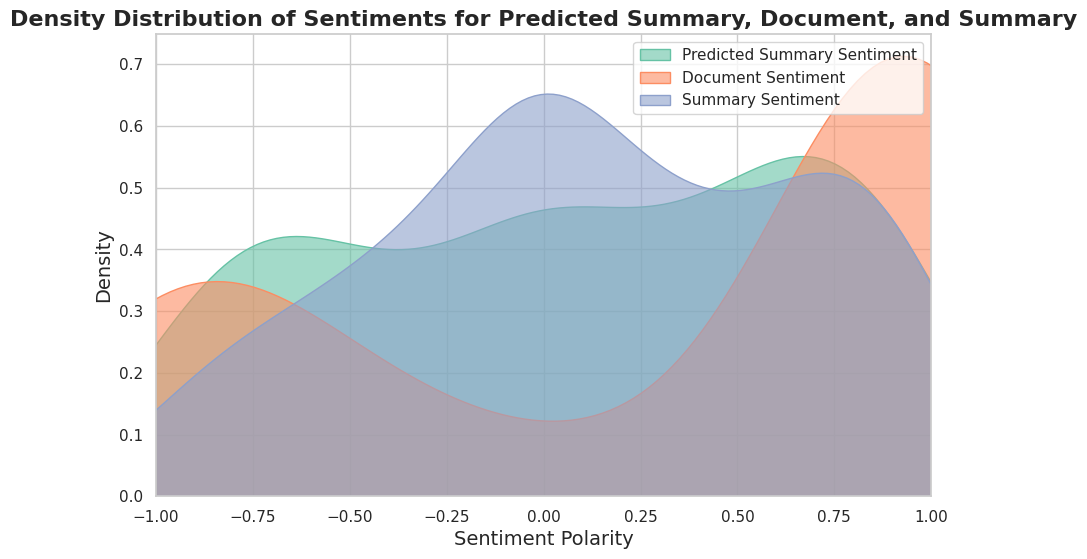

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style for a clean look
sns.set(style="whitegrid")

# Custom color palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Melting the DataFrame for use in seaborn
melted_data = sampled_data.melt(value_vars=['predicted_summary_sentiment', 'document_sentiment', 'summary_sentiment'],
                                var_name='Type', value_name='Sentiment')

# Creating a figure
plt.figure(figsize=(10, 6))

# KDE plot for density distribution
sns.kdeplot(data=melted_data[melted_data['Type'] == 'predicted_summary_sentiment'],
            x='Sentiment', color=colors[0], fill=True, label='Predicted Summary Sentiment', alpha=0.6)
sns.kdeplot(data=melted_data[melted_data['Type'] == 'document_sentiment'],
            x='Sentiment', color=colors[1], fill=True, label='Document Sentiment', alpha=0.6)
sns.kdeplot(data=melted_data[melted_data['Type'] == 'summary_sentiment'],
            x='Sentiment', color=colors[2], fill=True, label='Summary Sentiment', alpha=0.6)

# Title and labels with custom font sizes
plt.title('Density Distribution of Sentiments for Predicted Summary, Document, and Summary',
          fontsize=16, weight='bold')
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Adding legend
plt.legend()

# Adjusting x-axis limits for better visualization
plt.xlim(-1, 1)

# Displaying the plot
plt.show()

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Function to compute cosine similarity between two text vectors
def compute_cosine_similarity(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0, 0]

# Vectorize the documents, summaries, and predicted summaries (text columns only)
document_vectors = vectorizer.fit_transform(sampled_data['document'])
summary_vectors = vectorizer.transform(sampled_data['summary'])
predicted_summary_vectors = vectorizer.transform(sampled_data['predicted_summary'])

# Calculate and store cosine similarity for each pair
similarities_doc_summary = []
similarities_summary_predicted = []
similarities_doc_predicted = []

for idx, row in sampled_data.iterrows():
    # Get vector for the current document, summary, and predicted summary
    doc_vec = document_vectors[idx].toarray().flatten()
    summ_vec = summary_vectors[idx].toarray().flatten()
    pred_summ_vec = predicted_summary_vectors[idx].toarray().flatten()

    # Compute cosine similarities and append to lists
    similarities_doc_summary.append(compute_cosine_similarity(doc_vec, summ_vec))
    similarities_summary_predicted.append(compute_cosine_similarity(summ_vec, pred_summ_vec))
    similarities_doc_predicted.append(compute_cosine_similarity(doc_vec, pred_summ_vec))

# Add the new columns to the DataFrame
sampled_data['cosine_sim_doc_summary'] = similarities_doc_summary
sampled_data['cosine_sim_summary_predicted'] = similarities_summary_predicted
sampled_data['cosine_sim_doc_predicted'] = similarities_doc_predicted

# Check the resulting DataFrame
sampled_data[['cosine_sim_doc_summary', 'cosine_sim_summary_predicted', 'cosine_sim_doc_predicted']].head()

,cosine_sim_doc_summary,cosine_sim_summary_predicted,cosine_sim_doc_predicted
0,0.369598,0.181870,0.829794
1,0.249447,0.142071,0.317942
2,0.192208,0.345201,0.691585
3,0.230959,0.160283,0.393323
4,0.304891,0.233306,0.763617


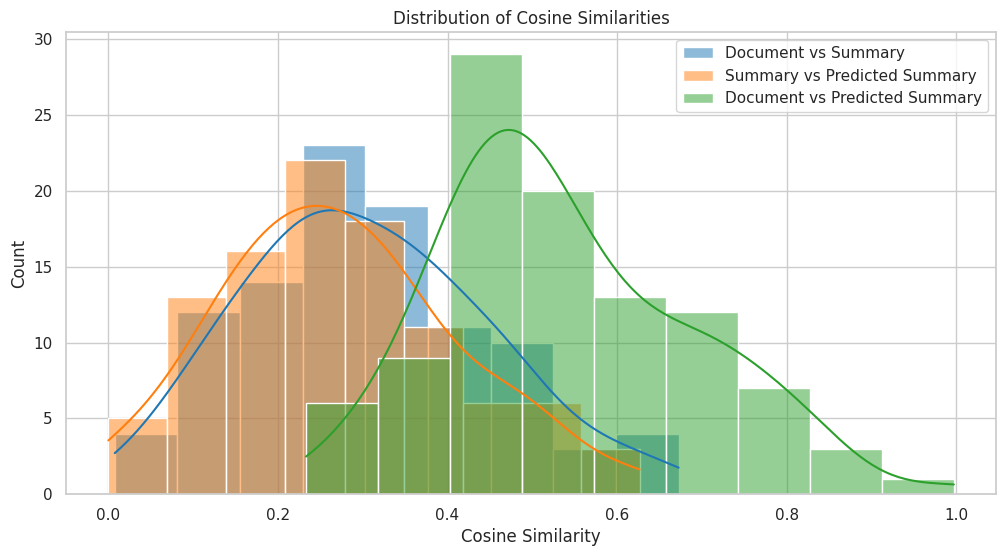

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(sampled_data['cosine_sim_doc_summary'], color="#1f77b4", label="Document vs Summary", kde=True)  # Blue
sns.histplot(sampled_data['cosine_sim_summary_predicted'], color="#ff7f0e", label="Summary vs Predicted Summary", kde=True)  # Orange
sns.histplot(sampled_data['cosine_sim_doc_predicted'], color="#2ca02c", label="Document vs Predicted Summary", kde=True)  # Green
plt.legend()
plt.xlabel("Cosine Similarity")
plt.title("Distribution of Cosine Similarities")
plt.show()